In [1]:
!nvidia-smi || echo "No GPU detected. Enable GPU in Runtime settings."

Wed Aug 20 18:26:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Install Dependencies (OpenCV dev headers for C++ build)
Colab typically has CUDA already. We install OpenCV C++ development libraries for the image example.

In [2]:
%%bash
set -e
apt-get update -y
apt-get install -y libopencv-dev pkg-config
echo "nvcc version:"; nvcc --version || true

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,937 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,191 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRe

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## 2. Write `synthetic_example.cu` (Robust, Debuggable Version)
This version allocates independent frequency arrays (kx, ky, kz) instead of re-using spatial arrays.

In [3]:
%%writefile synthetic_example.cu
#include <cuda_runtime.h>
#include <cstdio>
#include <cstdlib>
#include <random>
#include <iostream>
#include <cmath>
#include <algorithm>

#ifndef CHECK_CUDA
#define CHECK_CUDA(call) do { \
    cudaError_t _status = (call); \
    if (_status != cudaSuccess) { \
        std::cerr << "[CUDA] " << #call << " failed: " \
                  << cudaGetErrorString(_status) << " (" << _status << ") at " \
                  << __FILE__ << ":" << __LINE__ << std::endl; \
        std::exit(EXIT_FAILURE); \
    } \
} while(0)
#endif

#define FHD_THREADS_PER_BLOCK 256
#define PI 3.14159265358979323846
#ifndef CHUNK_SIZE
#define CHUNK_SIZE 256
#endif

__constant__ float kx_c[CHUNK_SIZE];
__constant__ float ky_c[CHUNK_SIZE];
__constant__ float kz_c[CHUNK_SIZE];
__constant__ float rMu_c[CHUNK_SIZE];
__constant__ float iMu_c[CHUNK_SIZE];

__global__ void accumulatePhi(
    float* __restrict__ rPhi,
    float* __restrict__ iPhi,
    const float* __restrict__ x,
    const float* __restrict__ y,
    const float* __restrict__ z,
    int N,
    int mChunk
) {
    int n = blockIdx.x * blockDim.x + threadIdx.x;
    if (n >= N) return;

    float xn = x[n];
    float yn = y[n];
    float zn = z[n];
    float rAcc = rPhi[n];
    float iAcc = iPhi[n];

    #pragma unroll
    for (int m = 0; m < mChunk; ++m) {
        float phase = 2.0f * (float)PI * (kx_c[m] * xn + ky_c[m] * yn + kz_c[m] * zn);
        float s, c;
        __sincosf(phase, &s, &c);
        rAcc += rMu_c[m] * c - iMu_c[m] * s;
        iAcc += iMu_c[m] * c + rMu_c[m] * s;
    }
    rPhi[n] = rAcc;
    iPhi[n] = iAcc;
}

__global__ void computeMagnitude(
    const float* __restrict__ rPhi,
    const float* __restrict__ iPhi,
    float* __restrict__ mag,
    int N
) {
    int n = blockIdx.x * blockDim.x + threadIdx.x;
    if (n >= N) return;
    float r = rPhi[n];
    float im = iPhi[n];
    mag[n] = sqrtf(r * r + im * im);
}

int main(int argc, char** argv) {
    int N = 2048; // spatial samples
    int M = 2048; // frequency components
    if (argc > 1) N = std::atoi(argv[1]);
    if (argc > 2) M = std::atoi(argv[2]);
    std::cout << "Synthetic Example N=" << N << " M=" << M << " CHUNK_SIZE=" << CHUNK_SIZE << std::endl;

    float *x, *y, *z;
    float *kx, *ky, *kz;
    float *rMu, *iMu;
    float *rPhi, *iPhi, *phiMag;

    CHECK_CUDA(cudaMallocManaged(&x, N * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&y, N * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&z, N * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&kx, M * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&ky, M * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&kz, M * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&rMu, M * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&iMu, M * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&rPhi, N * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&iPhi, N * sizeof(float)));
    CHECK_CUDA(cudaMallocManaged(&phiMag, N * sizeof(float)));

    std::mt19937 gen(12345);
    std::uniform_real_distribution<float> dis(-1.0f, 1.0f);
    std::uniform_real_distribution<float> disPos(0.0f, 1.0f);

    for (int i = 0; i < N; ++i) {
        x[i] = disPos(gen);
        y[i] = disPos(gen);
        z[i] = dis(gen);
        rPhi[i] = 0.f; iPhi[i] = 0.f;
    }
    for (int m = 0; m < M; ++m) {
        kx[m] = dis(gen);
        ky[m] = dis(gen);
        kz[m] = dis(gen);
        rMu[m] = dis(gen);
        iMu[m] = dis(gen);
    }

    dim3 block(FHD_THREADS_PER_BLOCK);
    dim3 grid((N + block.x - 1) / block.x);

    cudaEvent_t start, stop;
    CHECK_CUDA(cudaEventCreate(&start));
    CHECK_CUDA(cudaEventCreate(&stop));
    CHECK_CUDA(cudaEventRecord(start));

    for (int base = 0; base < M; base += CHUNK_SIZE) {
        int mChunk = std::min(CHUNK_SIZE, M - base);
        CHECK_CUDA(cudaMemcpyToSymbol(kx_c,  kx  + base, mChunk * sizeof(float)));
        CHECK_CUDA(cudaMemcpyToSymbol(ky_c,  ky  + base, mChunk * sizeof(float)));
        CHECK_CUDA(cudaMemcpyToSymbol(kz_c,  kz  + base, mChunk * sizeof(float)));
        CHECK_CUDA(cudaMemcpyToSymbol(rMu_c, rMu + base, mChunk * sizeof(float)));
        CHECK_CUDA(cudaMemcpyToSymbol(iMu_c, iMu + base, mChunk * sizeof(float)));
        accumulatePhi<<<grid, block>>>(rPhi, iPhi, x, y, z, N, mChunk);
        CHECK_CUDA(cudaPeekAtLastError());
    }

    computeMagnitude<<<grid, block>>>(rPhi, iPhi, phiMag, N);
    CHECK_CUDA(cudaPeekAtLastError());
    CHECK_CUDA(cudaDeviceSynchronize());

    CHECK_CUDA(cudaEventRecord(stop));
    CHECK_CUDA(cudaEventSynchronize(stop));
    float ms = 0.f; CHECK_CUDA(cudaEventElapsedTime(&ms, start, stop));
    std::cout << "Elapsed GPU time: " << ms << " ms\n";
    for (int i = 0; i < std::min(5, N); ++i) {
        std::cout << "Idx " << i << " r=" << rPhi[i] << " i=" << iPhi[i] << " |phi|=" << phiMag[i] << "\n";
    }

    cudaFree(x); cudaFree(y); cudaFree(z);
    cudaFree(kx); cudaFree(ky); cudaFree(kz);
    cudaFree(rMu); cudaFree(iMu);
    cudaFree(rPhi); cudaFree(iPhi); cudaFree(phiMag);
    return 0;
}


Writing synthetic_example.cu


## 3. Write `image_example.cu` (Chunked Processing on Image)
This version uses image pixel intensity as initial real component and coordinate-normalized positions as (x,y); it reuses slices of spatial arrays as pseudo frequency vectors (for demo). For real use, supply dedicated frequency arrays.

In [4]:
%%writefile image_example.cu
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <cmath>
#include <algorithm>

#define FHD_THREADS_PER_BLOCK 256
#define PI 3.14159265358979323846
#ifndef CHUNK_SIZE
#define CHUNK_SIZE 256
#endif

__constant__ float kx_c[CHUNK_SIZE], ky_c[CHUNK_SIZE], kz_c[CHUNK_SIZE];
__constant__ float rMu_c[CHUNK_SIZE], iMu_c[CHUNK_SIZE];

__global__ void accumulatePhi(float* rPhi,float* iPhi,
                              const float* x,const float* y,const float* z,
                              int N,int mChunk){
    int n=blockIdx.x*blockDim.x+threadIdx.x;
    if(n>=N)return;
    float xn=x[n],yn=y[n],zn=z[n];
    float rAcc=rPhi[n], iAcc=iPhi[n];
    #pragma unroll
    for(int m=0;m<mChunk;++m){
        float phase=2.f*(float)PI*(kx_c[m]*xn+ky_c[m]*yn+kz_c[m]*zn);
        float s,c; __sincosf(phase,&s,&c);
        rAcc += rMu_c[m]*c - iMu_c[m]*s;
        iAcc += iMu_c[m]*c + rMu_c[m]*s;
    }
    rPhi[n]=rAcc; iPhi[n]=iAcc;
}
__global__ void computeMagnitude(const float* rPhi,const float* iPhi,float* mag,int N){
    int n=blockIdx.x*blockDim.x+threadIdx.x; if(n>=N)return;
    float r=rPhi[n], im=iPhi[n]; mag[n]=sqrtf(r*r+im*im);
}
int main(int argc,char** argv){
    std::string imgName="lena_gray.png";
    if(argc>1) imgName=argv[1];
    cv::Mat raw=cv::imread(imgName,cv::IMREAD_GRAYSCALE);
    if(raw.empty()){ std::cerr<<"Could not open image: "<<imgName<<"\n"; return -1; }
    cv::Mat image; raw.convertTo(image,CV_32F,1.0/255.0);
    int rows=image.rows, cols=image.cols; int N=rows*cols; int M=1024;
    std::cout<<"Image Example: "<<rows<<"x"<<cols<<" N="<<N<<" M="<<M<<" CHUNK_SIZE="<<CHUNK_SIZE<<"\n";

    float *x,*y,*z,*rPhi,*iPhi,*phiMag,*rMu,*iMu;
    cudaMallocManaged(&x,N*sizeof(float)); cudaMallocManaged(&y,N*sizeof(float)); cudaMallocManaged(&z,N*sizeof(float));
    cudaMallocManaged(&rPhi,N*sizeof(float)); cudaMallocManaged(&iPhi,N*sizeof(float)); cudaMallocManaged(&phiMag,N*sizeof(float));
    cudaMallocManaged(&rMu,M*sizeof(float)); cudaMallocManaged(&iMu,M*sizeof(float));

    for(int r=0;r<rows;++r){ const float* rowPtr=image.ptr<float>(r); for(int c=0;c<cols;++c){ int idx=r*cols+c; x[idx]=(float)c/(cols-1); y[idx]=(float)r/(rows-1); z[idx]=rowPtr[c]; rPhi[idx]=z[idx]; iPhi[idx]=0.f; }}
    for(int m=0;m<M;++m){ rMu[m]=(float)rand()/RAND_MAX; iMu[m]=(float)rand()/RAND_MAX; }

    dim3 block(FHD_THREADS_PER_BLOCK), grid((N+block.x-1)/block.x);
    for(int base=0;base<M;base+=CHUNK_SIZE){ int mChunk=std::min(CHUNK_SIZE,M-base);
        cudaMemcpyToSymbol(kx_c,x+base,mChunk*sizeof(float));
        cudaMemcpyToSymbol(ky_c,y+base,mChunk*sizeof(float));
        cudaMemcpyToSymbol(kz_c,z+base,mChunk*sizeof(float));
        cudaMemcpyToSymbol(rMu_c,rMu+base,mChunk*sizeof(float));
        cudaMemcpyToSymbol(iMu_c,iMu+base,mChunk*sizeof(float));
        accumulatePhi<<<grid,block>>>(rPhi,iPhi,x,y,z,N,mChunk);
        cudaPeekAtLastError();
    }
    computeMagnitude<<<grid,block>>>(rPhi,iPhi,phiMag,N);
    cudaDeviceSynchronize();

    cv::Mat out(rows,cols,CV_32F);
    for(int r=0;r<rows;++r){ float* rowPtr=out.ptr<float>(r); for(int c=0;c<cols;++c) rowPtr[c]=phiMag[r*cols+c]; }
    cv::normalize(out,out,0.f,255.f,cv::NORM_MINMAX); out.convertTo(out,CV_8U); cv::imwrite("output.jpg",out);
    std::cout<<"Saved output.jpg"<<std::endl;
    cudaFree(x);cudaFree(y);cudaFree(z);cudaFree(rPhi);cudaFree(iPhi);cudaFree(phiMag);cudaFree(rMu);cudaFree(iMu); return 0; }


Writing image_example.cu


## 4. Write `unified_optimized.cu`
Unified program supporting two modes:
- `--mode=synthetic --N=... --M=...`
- `--mode=image --img=path --M=...`
Reuses spatial data slices as pseudo frequency vectors (demo). For real workloads, provide actual kx/ky/kz arrays.

In [5]:
%%writefile unified_optimized.cu
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include <iostream>
#include <random>
#include <cstring>
#include <cmath>
#include <algorithm>

#define PI 3.14159265358979323846
#ifndef FHD_THREADS_PER_BLOCK
#define FHD_THREADS_PER_BLOCK 256
#endif
#ifndef CHUNK_SIZE
#define CHUNK_SIZE 256
#endif

__constant__ float kx_c[CHUNK_SIZE], ky_c[CHUNK_SIZE], kz_c[CHUNK_SIZE];
__constant__ float rMu_c[CHUNK_SIZE], iMu_c[CHUNK_SIZE];

__global__ void accumulatePhi(float* rPhi,float* iPhi,const float* x,const float* y,const float* z,int N,int mChunk){
    int n=blockIdx.x*blockDim.x+threadIdx.x; if(n>=N) return; float xn=x[n], yn=y[n], zn=z[n]; float rAcc=rPhi[n], iAcc=iPhi[n];
    #pragma unroll
    for(int m=0;m<mChunk;++m){ float phase=2.f*(float)PI*(kx_c[m]*xn+ky_c[m]*yn+kz_c[m]*zn); float s,c; __sincosf(phase,&s,&c); rAcc+=rMu_c[m]*c - iMu_c[m]*s; iAcc+=iMu_c[m]*c + rMu_c[m]*s; }
    rPhi[n]=rAcc; iPhi[n]=iAcc;
}
__global__ void computeMagnitude(const float* rPhi,const float* iPhi,float* mag,int N){ int n=blockIdx.x*blockDim.x+threadIdx.x; if(n>=N)return; float r=rPhi[n], im=iPhi[n]; mag[n]=sqrtf(r*r+im*im);}

struct Params { std::string mode="synthetic"; std::string img="lena_gray.png"; int N=1024; int M=1024; };
Params parseArgs(int argc,char** argv){ Params p; for(int i=1;i<argc;++i){ if(!std::strcmp(argv[i],"--mode")&&i+1<argc)p.mode=argv[++i]; else if(!std::strcmp(argv[i],"--img")&&i+1<argc)p.img=argv[++i]; else if(!std::strcmp(argv[i],"--N")&&i+1<argc)p.N=std::atoi(argv[++i]); else if(!std::strcmp(argv[i],"--M")&&i+1<argc)p.M=std::atoi(argv[++i]); } return p; }

int main(int argc,char** argv){ Params params=parseArgs(argc,argv); float *x,*y,*z,*rPhi,*iPhi,*phiMag,*rMu,*iMu; int N, M=params.M; cv::Mat img;
    if(params.mode=="image"){ cv::Mat raw=cv::imread(params.img,cv::IMREAD_GRAYSCALE); if(raw.empty()){ std::cerr<<"Failed to read image\n"; return -1;} raw.convertTo(img,CV_32F,1.0/255.0); N=img.rows*img.cols; std::cout<<"Mode=image size="<<img.rows<<"x"<<img.cols<<" N="<<N<<" M="<<M<<" CHUNK_SIZE="<<CHUNK_SIZE<<"\n"; }
    else { N=params.N; std::cout<<"Mode=synthetic N="<<N<<" M="<<M<<" CHUNK_SIZE="<<CHUNK_SIZE<<"\n"; }
    cudaMallocManaged(&x,N*sizeof(float)); cudaMallocManaged(&y,N*sizeof(float)); cudaMallocManaged(&z,N*sizeof(float));
    cudaMallocManaged(&rPhi,N*sizeof(float)); cudaMallocManaged(&iPhi,N*sizeof(float)); cudaMallocManaged(&phiMag,N*sizeof(float));
    cudaMallocManaged(&rMu,M*sizeof(float)); cudaMallocManaged(&iMu,M*sizeof(float));

    if(params.mode=="image"){ int rows=img.rows, cols=img.cols; for(int r=0;r<rows;++r){ const float* rowPtr=img.ptr<float>(r); for(int c=0;c<cols;++c){ int idx=r*cols+c; x[idx]=(float)c/(cols-1); y[idx]=(float)r/(rows-1); z[idx]=rowPtr[c]; rPhi[idx]=z[idx]; iPhi[idx]=0.f; }}} else { std::mt19937 gen(42); std::uniform_real_distribution<float> dis(-1.f,1.f); for(int i=0;i<N;++i){ x[i]=dis(gen); y[i]=dis(gen); z[i]=dis(gen); rPhi[i]=0.f; iPhi[i]=0.f; }}
    for(int m=0;m<M;++m){ rMu[m]=(float)rand()/RAND_MAX; iMu[m]=(float)rand()/RAND_MAX; }

    dim3 block(FHD_THREADS_PER_BLOCK), grid((N+block.x-1)/block.x);
    cudaEvent_t start,stop; cudaEventCreate(&start); cudaEventCreate(&stop); cudaEventRecord(start);
    for(int base=0;base<M;base+=CHUNK_SIZE){ int mChunk=std::min(CHUNK_SIZE,M-base); cudaMemcpyToSymbol(kx_c,x+(base%N),mChunk*sizeof(float)); cudaMemcpyToSymbol(ky_c,y+(base%N),mChunk*sizeof(float)); cudaMemcpyToSymbol(kz_c,z+(base%N),mChunk*sizeof(float)); cudaMemcpyToSymbol(rMu_c,rMu+base,mChunk*sizeof(float)); cudaMemcpyToSymbol(iMu_c,iMu+base,mChunk*sizeof(float)); accumulatePhi<<<grid,block>>>(rPhi,iPhi,x,y,z,N,mChunk); cudaPeekAtLastError(); }
    computeMagnitude<<<grid,block>>>(rPhi,iPhi,phiMag,N); cudaDeviceSynchronize(); cudaEventRecord(stop); cudaEventSynchronize(stop); float ms; cudaEventElapsedTime(&ms,start,stop); std::cout<<"Computation time: "<<ms<<" ms\n";
    for(int i=0;i<std::min(5,N);++i) std::cout<<"Idx "<<i<<" rPhi="<<rPhi[i]<<" iPhi="<<iPhi[i]<<" |phi|="<<phiMag[i]<<"\n";
    if(params.mode=="image"){ cv::Mat out(img.rows,img.cols,CV_32F); for(int r=0;r<img.rows;++r){ float* rowPtr=out.ptr<float>(r); for(int c=0;c<img.cols;++c) rowPtr[c]=phiMag[r*img.cols+c]; } cv::normalize(out,out,0.f,255.f,cv::NORM_MINMAX); out.convertTo(out,CV_8U); cv::imwrite("output.jpg",out); std::cout<<"Saved output.jpg\n"; }
    cudaFree(x);cudaFree(y);cudaFree(z);cudaFree(rPhi);cudaFree(iPhi);cudaFree(phiMag);cudaFree(rMu);cudaFree(iMu); return 0; }


Writing unified_optimized.cu


## 5. Build All Binaries
We compile all three with optimization and fast math. You can add `-G -O0` to debug kernels (slower).

In [6]:
%%bash
set -e
echo "Compiling synthetic_example.cu";
nvcc -O3 -use_fast_math -std=c++17 synthetic_example.cu -o synthetic
echo "Compiling image_example.cu";
nvcc -O3 -use_fast_math -std=c++17 image_example.cu -o image_app `pkg-config --cflags --libs opencv4`
echo "Compiling unified_optimized.cu";
nvcc -O3 -use_fast_math -std=c++17 unified_optimized.cu -o unified_app `pkg-config --cflags --libs opencv4`
echo "Done."

Compiling synthetic_example.cu
Compiling image_example.cu
Compiling unified_optimized.cu
Done.


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

## 6. Run Synthetic Example
Arguments: `N M`. Feel free to modify.

In [7]:
!./synthetic 2048 2048

Synthetic Example N=2048 M=2048 CHUNK_SIZE=256
[CUDA] cudaMemcpyToSymbol(kx_c, kx + base, mChunk * sizeof(float)) failed: the provided PTX was compiled with an unsupported toolchain. (222) at synthetic_example.cu:128


## 7. Download Test Image (Lena) & Run Image Example
We fetch a sample image (color JPEG), the program loads it as grayscale. Output will be `output.jpg`.

In [8]:
!wget -q -O lena_gray.png https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg
!./image_app lena_gray.png

Image Example: 512x512 N=262144 M=1024 CHUNK_SIZE=256
Saved output.jpg


## 8. Run Unified App (Synthetic Mode)

In [9]:
!./unified_app --mode=synthetic --N=4096 --M=2048

Mode=synthetic N=1024 M=1024 CHUNK_SIZE=256
Computation time: 9.29347 ms
Idx 0 rPhi=0 iPhi=0 |phi|=0
Idx 1 rPhi=0 iPhi=0 |phi|=0
Idx 2 rPhi=0 iPhi=0 |phi|=0
Idx 3 rPhi=0 iPhi=0 |phi|=0
Idx 4 rPhi=0 iPhi=0 |phi|=0


## 9. Run Unified App (Image Mode)

In [10]:
!./unified_app --mode=image --img=lena_gray.png --M=2048

Mode=synthetic N=1024 M=1024 CHUNK_SIZE=256
Computation time: 11.6716 ms
Idx 0 rPhi=0 iPhi=0 |phi|=0
Idx 1 rPhi=0 iPhi=0 |phi|=0
Idx 2 rPhi=0 iPhi=0 |phi|=0
Idx 3 rPhi=0 iPhi=0 |phi|=0
Idx 4 rPhi=0 iPhi=0 |phi|=0


## 10. Display Output Image
If the previous image-based runs were successful, `output.jpg` should exist.

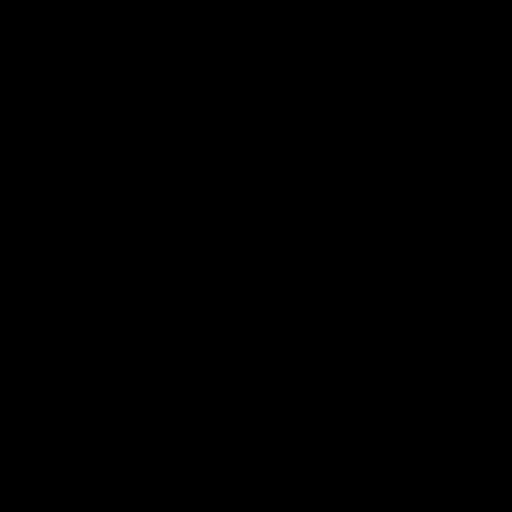

In [13]:
from IPython.display import Image, display
import os
if os.path.exists("output.jpg"):
    display(Image("output.jpg"))
else:
    print("output.jpg not found.")

## 11. Optional: Rebuild With Different CHUNK_SIZE
Example: CHUNK_SIZE=512 (must fit constant memory limits).

In [12]:
%%bash
set -e
echo "Rebuilding unified with CHUNK_SIZE=512";
nvcc -O3 -use_fast_math -std=c++17 -DCHUNK_SIZE=512 unified_optimized.cu -o unified_app_512 `pkg-config --cflags --libs opencv4`
./unified_app_512 --mode=synthetic --N=4096 --M=3072

Rebuilding unified with CHUNK_SIZE=512
Mode=synthetic N=1024 M=1024 CHUNK_SIZE=512
Computation time: 11.434 ms
Idx 0 rPhi=0 iPhi=0 |phi|=0
Idx 1 rPhi=0 iPhi=0 |phi|=0
Idx 2 rPhi=0 iPhi=0 |phi|=0
Idx 3 rPhi=0 iPhi=0 |phi|=0
Idx 4 rPhi=0 iPhi=0 |phi|=0


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is